

# Finetuning modelo ProtT5-XL-U50 para predecir la temperatura de melting de proteínas

Este notebook consiste en una adaptación de la propuesta para realizar *finetuning* al modelo ProtT5-XL-U50, utilizando LoRA, desarrollada por los autores de este modelo Elnaggar et al. (2022). La implementación que fue adoptada en este notebook está disponible [aquí](https://github.com/agemagician/ProtTrans/blob/master) y el articulo original donde se publicó este modelo se  encuentra en este [enlace](https://ieeexplore.ieee.org/document/9477085).

### Importación de librerias 


In [1]:
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy
import pandas as pd
import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

2025-05-24 23:48:36.496853: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Establecer directorio de salida

In [2]:
# Ruta donde se guardarán los pesos entrenados del modelo y demás archivos
os.chdir("/home/sis.virtual.uniandes.edu.co/as.villa/proyecto/finetuning/results/ProtT5_finetuning")


In [3]:
# Establecer variables para correr Deepspeed
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "8000"
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

###  Ambiente utilizado para correr este notebook

Se utilizó la configuración de este [archivo](https://github.com/agemagician/ProtTrans/blob/master/Fine-Tuning/finetuning.yml)  para crear un ambiente de conda para realizar el *finetuning*. 
Estas son las versiones de los paquetes principales utilizados en este notebook:

In [4]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  1.13.1
Cuda version:  11.7
Numpy version:  1.22.3
Pandas version:  1.5.3
Transformers version:  4.26.1
Datasets version:  2.9.0



# Datos

En este apartado se hace el cargue de los datos utilizados por [Rodella et al. (2024)](https://academic.oup.com/bioinformaticsadvances/article/4/1/vbae103/7713394) para el entrenamiento, validación y evalución de TemBERTure. Sin embargo, a estos datos se les hizo un preprocesamiento, por lo que los datos utilizados finalmente se encuentran en nuestro repositorio en esta [ruta](https://github.com/asvilla/ProtT5MP/blob/main/data/processed/preprocessed_data.tar.gz) y son lo siguientes: 

- train_preprocessed.txt: Conjunto de entrenamiento
- val_preprocessed.txt: Conjunto de validación
- test_preprocessed.txt: Conjunto de prueba.

### Entrenamiento
 

In [5]:
train = pd.read_csv("/home/sis.virtual.uniandes.edu.co/as.villa/proyecto/data/preprocessed_data/train_preprocessed.txt", sep=",", dtype=str, skipinitialspace=True)
train

,Protein_ID,Sequence,Sequence_Length,Type,Tm,PDB_Path,Unique_ID
0,P94532,MNAVTIVIASMCILAIAYRLYGTFMMVKVLKVNDDKPTPAHALEDG...,598,Non-thermophilic,31.257,estructuras/train/P94532.pdb.gz,P94532_0
1,P94532,MNAVTIVIASMCILAIAYRLYGTFMMVKVLKVNDDKPTPAHALEDG...,598,Non-thermophilic,31.257,estructuras/train/P94532.pdb.gz,P94532_1
2,P94532,MNAVTIVIASMCILAIAYRLYGTFMMVKVLKVNDDKPTPAHALEDG...,598,Non-thermophilic,31.257,estructuras/train/P94532.pdb.gz,P94532_2
3,P94532,MNAVTIVIASMCILAIAYRLYGTFMMVKVLKVNDDKPTPAHALEDG...,598,Non-thermophilic,31.257,estructuras/train/P94532.pdb.gz,P94532_3
4,P94532,MNAVTIVIASMCILAIAYRLYGTFMMVKVLKVNDDKPTPAHALEDG...,598,Non-thermophilic,31.257,estructuras/train/P94532.pdb.gz,P94532_4
...,...,...,...,...,...,...,...
28738,Q72LM0,MRRTVKDFRNAKGQRLVYLTAYDYPTARLAEAAGVDAILVGDSLGM...,261,Thermophilic,98.742,estructuras/train/Q72LM0.pdb.gz,Q72LM0_345
28739,Q72LM0,MRRTVKDFRNAKGQRLVYLTAYDYPTARLAEAAGVDAILVGDSLGM...,261,Thermophilic,98.742,estructuras/train/Q72LM0.pdb.gz,Q72LM0_346
28740,Q72LM0,MRRTVKDFRNAKGQRLVYLTAYDYPTARLAEAAGVDAILVGDSLGM...,261,Thermophilic,98.742,estructuras/train/Q72LM0.pdb.gz,Q72LM0_347
28741,Q72LM0,MRRTVKDFRNAKGQRLVYLTAYDYPTARLAEAAGVDAILVGDSLGM...,261,Thermophilic,98.742,estructuras/train/Q72LM0.pdb.gz,Q72LM0_348


### Validación

In [6]:
valid = pd.read_csv("/home/sis.virtual.uniandes.edu.co/as.villa/proyecto/data/preprocessed_data/val_preprocessed.txt", sep=",", dtype=str, skipinitialspace=True)
valid

,Protein_ID,Sequence,Sequence_Length,Type,Tm,PDB_Path,Unique_ID
0,A0A0K2H545,MAKRERKGGLSGRQKAAILLISLGPDVSASVYKHLSEEEIEKLTLE...,339,Thermophilic,70.523,estructuras/val/A0A0K2H545.pdb.gz,A0A0K2H545_0
1,P61671,MGNMLKGEGPGPLPPLLQQYVELRDRYPDYLLLFQVGDFYECFGED...,811,Thermophilic,76.259,estructuras/val/P61671.pdb.gz,P61671_0
2,Q72KI6,MERELAHWVERLRERAEAEGLSFPPVAFQEVGPEEMAMLAAYGGFP...,456,Thermophilic,76.48899999999998,estructuras/val/Q72KI6.pdb.gz,Q72KI6_0
3,Q746B7,MAWLNPFWSSPKAYVRPPKRGLAPELWASRIPFTHLENFYEVFRAL...,1042,Thermophilic,76.77199999999998,estructuras/val/Q746B7.pdb.gz,Q746B7_0
4,Q72IX8,MKAFWDYLFKEWFRQVGEALLVAFLVTTFVFTTVGVVGQSMYPTLR...,267,Thermophilic,77.617,estructuras/val/Q72IX8.pdb.gz,Q72IX8_0
...,...,...,...,...,...,...,...
508,Q9JIB0,MEPNRNCPLFGGAFSAILPTGAIDVSDLRPVPDNQEVFCHPVTDQS...,185,Non-thermophilic,52.833,estructuras/val/Q9JIB0.pdb.gz,Q9JIB0_0
509,Q8BK72,MAAPMVRCGMLLARRLDASRLCLAGKRCLLSAAYVDSHQWEAREKE...,415,Non-thermophilic,52.83600000000001,estructuras/val/Q8BK72.pdb.gz,Q8BK72_0
510,O88839,MRLALLWALGLLGAGSPRPSPPLPNIGGTEEEQQASPERTLSGSME...,864,Non-thermophilic,52.846,estructuras/val/O88839.pdb.gz,O88839_0
511,Z4YML9,LCRRPAGAQLLRVALCLLCWVPAAVDAVPELGLWTRTVNDKSGPLV...,548,Non-thermophilic,52.851000000000006,estructuras/val/Z4YML9.pdb.gz,Z4YML9_0


### Evaluación

In [7]:
test = pd.read_csv("/home/sis.virtual.uniandes.edu.co/as.villa/proyecto/data/preprocessed_data/test_preprocessed.txt", sep=",", dtype=str, skipinitialspace=True)
test

,Protein_ID,Sequence,Sequence_Length,Type,Tm,PDB_Path,Unique_ID
0,A0A0K2H5Z1,MEKVYGLIGFPVEHSLSPLMHNDAFARLGIPARYHLFSVEPGQVGA...,276,Thermophilic,70.92,estructuras/test/A0A0K2H5Z1.pdb.gz,A0A0K2H5Z1_0
1,A0A0K2H966,MWKKFLSKLGIGAAKVDLVLHRPHVRLGETLEGEFLLEGGSVAQHI...,327,Thermophilic,71.73,estructuras/test/A0A0K2H966.pdb.gz,A0A0K2H966_0
2,A0A0K2H9T2,MKILLAEDDLHLGELIVHLLKKKGIDHIDWVQEGEDAYDYAMAEFY...,223,Thermophilic,71.946,estructuras/test/A0A0K2H9T2.pdb.gz,A0A0K2H9T2_0
3,A0A0K2HC89,MRKIVIVGGVAGGATAAARLRRLSEADHIVLFERGEYISFANCGLP...,547,Thermophilic,72.421,estructuras/test/A0A0K2HC89.pdb.gz,A0A0K2HC89_0
4,A0A0K2HCU8,MTVGKVYLVGAGPGDEKLITVYGRECLERADVIIYDRLINRKLLRY...,256,Thermophilic,74.42399999999999,estructuras/test/A0A0K2HCU8.pdb.gz,A0A0K2HCU8_0
...,...,...,...,...,...,...,...
518,Q8BGT0,MARDAELARSSGWPWRWLPALLLLQLLRWRCALCALPFTSSRHPGF...,338,Non-thermophilic,52.78,estructuras/test/Q8BGT0.pdb.gz,Q8BGT0_0
519,Q4V9R2,MTSLSVHTDSPSTQGEMAFNLTILSLTELLSLGGLLGNGVALWLLN...,310,Non-thermophilic,52.78,estructuras/test/Q4V9R2.pdb.gz,Q4V9R2_0
520,G3UW46,MAGAPGGGELGPAAGEPLLQRPDSGQGSPEPPAHGKPQQGFLSSLF...,246,Non-thermophilic,52.81800000000001,estructuras/test/G3UW46.pdb.gz,G3UW46_0
521,G5E8S0,MDRSSKRRQVKPLAASLLEALDYDSSDDSDFKVGDASDSEGSGNGS...,881,Non-thermophilic,58.234,estructuras/test/G5E8S0.pdb.gz,G5E8S0_0


### Unión de los conjuntos de datos

Dado que los datos obtenidos de [TemBERTure](https://github.com/ibmm-unibe-ch/TemBERTure) tienen una partición 96:2:2, que se utilizó en este estudio pero en otro notebook para realizar *finetuning* y provocó resultados defiientes en el entrenamiento y la evaluación, se quizo explorar el efecto de la partición  de los datos en el desempeño del modelo. Por esta razón se unieron los distintos datasets y se dividieron en una partición 80:10:10.

In [8]:
complete_data = pd.concat([train, valid, test], ignore_index=True)
complete_data = complete_data.sample(frac=1, random_state=42).reset_index(drop=True)
complete_data

,Protein_ID,Sequence,Sequence_Length,Type,Tm,PDB_Path,Unique_ID
0,A0A1D5NSR2,MATGKADEPAVQESHHECANNENEPAKDEKDTLQTGEVETMSKRQR...,166,Non-thermophilic,51.737,estructuras/train/A0A1D5NSR2.pdb.gz,A0A1D5NSR2_0
1,Q72IJ8,MIRTVALVGHAGSGKTTLTEALLYKTGAKERRGRVEEGTTTTDYTP...,658,Thermophilic,72.86,estructuras/train/Q72IJ8.pdb.gz,Q72IJ8_3
2,Q542D6,MRPEPGGCCCRRPMRANGCVKNGEVRNGYLRSSTATVAAAGQIHHV...,560,Non-thermophilic,49.183,estructuras/train/Q542D6.pdb.gz,Q542D6_0
3,Q72L41,MLVTGGAGFIGSHIVEDLLARGLEVAVLDNLATGKRENVPKGVPFF...,309,Thermophilic,83.228,estructuras/train/Q72L41.pdb.gz,Q72L41_1
4,Q6L2U7,MPVDFGIYHHSSREESEKLRNISKIMFIEAFKKLGYNGDEDINILD...,202,Thermophilic,69.82300000000001,estructuras/train/Q6L2U7.pdb.gz,Q6L2U7_0
...,...,...,...,...,...,...,...
29774,Q6L196,MDVLIVIDMLNDFIHGALKTDEALKTVGPASRVVEIFHNKNLPVIY...,176,Thermophilic,73.22,estructuras/train/Q6L196.pdb.gz,Q6L196_1
29775,O23144,MGVEVVNSGGFEVAPAPFEGKPEKNGKLDQGKGDDAPINFGSVGEL...,612,Non-thermophilic,43.529,estructuras/train/O23144.pdb.gz,O23144_0
29776,Q21503,MTDSVEICAAVITGFEKVAAKEISKLFSPKKCHPGRGNVRFSIDLE...,391,Non-thermophilic,34.514,estructuras/train/Q21503.pdb.gz,Q21503_2
29777,Q93096,MARMNRPAPVEVTYKNMRFLITHNPTNATLNKFIEELKKYGVTTIV...,173,Non-thermophilic,54.95,estructuras/train/Q93096.pdb.gz,Q93096_0


In [9]:
from sklearn.model_selection import train_test_split

# Separar los datos en una proporción 80:10:10 
train, temp_df = train_test_split(complete_data, test_size=0.2, random_state=42)
valid, test = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Train: {len(train)}, Valid: {len(valid)}, Test: {len(test)}")

Train: 23823, Valid: 2978, Test: 2978


### Preprocesamiento de los datos

In [10]:
def preprocessing (data):
    
    preprocessed = data[["Sequence","Tm"]]
    preprocessed = preprocessed.rename(columns={'Sequence': 'sequence', 'Tm': 'label'})
    preprocessed["label"] = preprocessed["label"].astype(float) 
    
    return preprocessed

In [11]:
my_train = preprocessing(train)
my_train

,sequence,label
27790,MARHIMAVCVVCLLCAHRLHCQDHIESLLGPARVTTHNSQDQLNAR...,45.143000
1383,MADPWQECMDYAVTLARQAGEVVCEAIKNEMNVMLKSSPVDLVTAT...,66.936000
20758,MDAIDFVKKNTEEIVTMDEAFKALNNNPKGYIGFEPSGNPHLGTCL...,74.207000
2441,MDAFRLAPCGPLRGRLRVPGDKSVTHRGLMLLALAEGEGRLFYPLK...,63.473325
21877,MNAINNQDSVFCPALFLTAPASGQGKTTVTAALARMLKRQGKVVRV...,36.595000
...,...,...
21575,MAVHTNRQILTRGKNYATKQSKKFGTDEVTFDKDSRLDYLTGFHKR...,44.199000
5390,MAFNFGAPSGTSGTSTATAAPAGGFGGFGTTTTTAGSAFSFSAPTN...,52.952000
860,MGKKSKNSVTTQTQWKRLKIDFVERKIDKDDVFFEEVSDEQLNDKI...,35.230000
15795,MQNSALKAWLDSSYLSGANQSWIEQLYEDFLTDPDSVDANWRSTFQ...,41.381000


In [12]:
my_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23823 entries, 27790 to 23654
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sequence  23823 non-null  object 
 1   label     23823 non-null  float64
dtypes: float64(1), object(1)
memory usage: 558.4+ KB


In [13]:
my_valid = preprocessing(valid)
my_valid

,sequence,label
16902,MNRIYIYSPLRVSFAGGGTDISPFPEKYGGAVLNVTIDRGILIKYI...,68.620000
19851,MENTDELVSIELPAPASWKKLFYPKRAGTPRKTEIVFVAPTGEEIS...,47.036000
8925,MDENRKLREQLMPALESKCDEFRLLGYTQVTMDGLWECLCSRKWKH...,74.168000
22545,MFNRPNRNDVDDGVQDIQNDVNQLADSLESVLKSWGSDAKGEAEAA...,59.659000
27709,MRRTVKDFRNAKGQRLVYLTAYDYPTARLAEAAGVDAILVGDSLGM...,98.742000
...,...,...
25864,MAEIGVAVVGGGWAGLAAALALKEAGADFLLLEASLRLGGKVRTAR...,74.842188
26482,MKILVTGHKGFIGGHIYNYLKSKNYDVYGYDIGDSLKDIKYDYIIH...,72.556000
15000,MKRKLLSSLAISALSLGLLVSAPTASFAAESTSTKAHTESTMRTQS...,48.508000
14483,MATVADVIVKTLVNFGVKRIYAIPGDSLNPIIDAIRRNRDIKYIQV...,66.054000


In [14]:
my_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2978 entries, 16902 to 1190
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sequence  2978 non-null   object 
 1   label     2978 non-null   float64
dtypes: float64(1), object(1)
memory usage: 69.8+ KB


In [15]:
my_test = preprocessing(test)
my_test

,sequence,label
14045,RGCKAFFKRTIRKDLTYTCRDIKECLIDKRQRNRCQYCRYQKCLAM...,53.295000
29025,MSKNNGKGAKGEFEFPQPAKKQTFSEMIYNPQEGTFFGRTGKSWSQ...,43.466000
25672,MYISLENDYVARVPPELLGDDYREAVLEITKRNLVGKLVDINDSTG...,77.379000
4306,MTAFLPPNLLALFEARPPVQYLPPCQDLLVDKNAKRAPMTGVAQYI...,33.498000
8278,MRAIRVHEVGGPEVLRLEELPVPEPGPGEVLVRLLAIGVNFIDTYK...,78.824346
...,...,...
12531,MKRKSKAGGASDKSKSPKLKKRRSVVLEPIHISPKYLEDKFKTEFK...,33.837000
6725,MKLIRGIHNLSQAPQEGCVLTIGNFDGVHRGHRALLQGLQEEGRKR...,47.054000
11189,MSGLRNTSEAVAVLASLGLGMVLLMFVATTPPAVEATQSGIYIDNG...,37.881000
27334,MEIKEEPCRIKDEETEELIDQTEVNEDKQNLFNNPEGFSGENPQIK...,50.711000


In [16]:
my_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2978 entries, 14045 to 23314
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sequence  2978 non-null   object 
 1   label     2978 non-null   float64
dtypes: float64(1), object(1)
memory usage: 69.8+ KB


In [54]:
# Verificar que las distribuciones de la variable objetivo sean similares en las tres particiones
print(my_train['label'].describe())
print(my_valid['label'].describe())
print(my_test['label'].describe())

count    23823.000000
mean        58.853001
std         17.419972
min         31.257000
25%         45.134000
50%         53.153000
75%         73.191000
max         98.742000
Name: label, dtype: float64
count    2978.000000
mean       58.933662
std        17.351003
min        31.257000
25%        45.323750
50%        53.214000
75%        72.821750
max        98.742000
Name: label, dtype: float64
count    2978.000000
mean       59.219720
std        17.535168
min        31.257000
25%        45.332250
50%        53.483000
75%        74.265000
max        98.742000
Name: label, dtype: float64


#  Modelo ProtT5 y Low Rank Adaptation

## Definición de la configuración de LoRA

In [18]:

class LoRAConfig:
    def __init__(self):
        self.lora_rank = 4
        self.lora_init_scale = 0.01
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = 1
        
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )

# Modificación del modelo introduciendo capas de LoRA
def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

## Definición del modelo de regresión


In [19]:
class RegressionConfig:
    def __init__(self, dropout=0.2, num_labels=1):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class T5EncoderRegresionHead(nn.Module):
    """Cabeza para tarea de regresión por proteína"""

    def __init__(self, config, regression_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(regression_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, regression_config.num_labels)

    def forward(self, hidden_states):

        hidden_states =  torch.mean(hidden_states,dim=1)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = torch.tanh(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.out_proj(hidden_states)
        return hidden_states

class T5EncoderForSimpleSequenceRegression(T5PreTrainedModel):

    def __init__(self, config: T5Config, regression_config):
        super().__init__(config)
        self.num_labels = regression_config.num_labels
        self.config = config

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = T5Stack(encoder_config, self.shared)

        self.dropout = nn.Dropout(regression_config.dropout_rate) 
        self.regressor = T5EncoderRegresionHead(config, regression_config)

        # Inicializar pesos
        self.post_init()
        
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.regressor = self.regressor.to(self.encoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)

    def get_encoder(self):
        return self.encoder

    def _prune_heads(self, heads_to_prune):
    
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        hidden_states = outputs[0]
        logits = self.regressor(hidden_states)

        loss = None
        if labels is not None:
            loss_fct = MSELoss()
            loss = loss_fct(logits.squeeze(), labels.squeeze())
                
        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

## Modificación del modelo ProtT5-XL-U50

En este apartado se crea un modelo ProtT5-XL-U50 con la cabeza de regresión y la modificación LoRA

In [20]:
def PT5_Regression_model(num_labels, half_precision):
    
    if not half_precision:
        model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
        # Imprimir la arquitectura del modelo
        print("ProtT5_Regressor\nArquitectura del modelo: "+ str(model))
        print("Número total de parámetros")
        print(f'{sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
        
        tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50")
        
    elif half_precision and torch.cuda.is_available() : 
        tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)
        model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc", torch_dtype=torch.float16).to(torch.device('cuda'))
        # Imprimir la arquitectura del modelo
        print("ProtT5_Regressor\nArquitectura del Mmdelo: "+ str(model))
        print("Número total de parámetros")
        print(f'{sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
        
    else:
          raise ValueError('Half precision solo se puede correr en GPU')
    
    # Crear un modelo de regresion con las dimensiones de PT5
    regression_config=RegressionConfig(num_labels=num_labels)
    regression_model=T5EncoderForSimpleSequenceRegression(model.config,regression_config)
    
    # Definir los pesos del encoder y embeddings a los pesos del checkpoint
    regression_model.shared=model.shared
    regression_model.encoder=model.encoder    
    
    # Eliminar el checkpoint del modelo
    model=regression_model
    del regression_model
    
    # Imprimir el numero de parametros entrenables
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_Regressor\nParámetros entrenables: "+ str(params))    
 
    # Añadir la modificación del modelo con LoRA
    config = LoRAConfig()
    
    # Añadir capas de LoRA
    model = modify_with_lora(model, config)
    
    # Congelar Embeddings y Encoder (excepto LoRA)
    for (param_name, param) in model.shared.named_parameters():
                param.requires_grad = False
    for (param_name, param) in model.encoder.named_parameters():
                param.requires_grad = False       

    for (param_name, param) in model.named_parameters():
            if re.fullmatch(config.trainable_param_names, param_name):
                param.requires_grad = True
                
    # Imprimir los parametros entrenables
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ProtT5_LoRA_Regressor\nParámetros entrenables: "+ str(params) + "\n")
    
    print("Parámetros entrenables:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)
    
    return model, tokenizer

# Entrenamiento

## Configuración de Deepspeed

In [21]:

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

## Funciones para el entrenamiento

In [22]:
from sklearn.metrics import r2_score
from evaluate import load
import numpy as np


# Establecer semillas aleatorias para reproducibilidad
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

# Creación del dataset
def create_dataset(tokenizer,seqs,labels):
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    dataset = dataset.add_column("labels", labels)

    return dataset
    
# Función de entreamiento
def train_per_protein(
        train_df,         # Datos de entrenamiento
        valid_df,         # Dato de validación      
        num_labels= 1,    # 1 para regressión
    
         
        batch= 4,         # Para entrenamiento
        accum= 2,         # gradiente de acumulación
    
        val_batch = 16,   # batch size para evaluacion
        epochs= 10,       # epochs de entrenamiento
        lr= 3e-4,         # Taza de aprendizaje
        seed= 42,         # random seed
        deepspeed= False, 
        mixed= False,     # mixed precision
        gpu= 1 ):         # Selección de GPU(1 para la primera)

    
    # Establecer las semillas aleatorias
    set_seeds(seed)
    
    # Gargar modelo
    model, tokenizer = PT5_Regression_model(num_labels=num_labels, half_precision=False)

    # Preprocesamiento de los inputs
    # Remplazar los AAs raros con "X"
    train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
    # Añadir espacios entre cada aminoacido
    train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
    valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)

    # Crear Datasets
    train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
    valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

    # Argumentos del Trainer de Huggingface
    args = TrainingArguments(
        "./",
        evaluation_strategy = "epoch",
        logging_strategy = "epoch",
        save_strategy = "no",
        learning_rate=lr,
        per_device_train_batch_size=batch,
        per_device_eval_batch_size=val_batch,
        gradient_accumulation_steps=accum,
        num_train_epochs=epochs,
        seed = seed,
        deepspeed= ds_config if deepspeed else None,
        fp16 = False,
        **{"local_rank": -1}, 
    ) 

    # Metricas de evaluación
    
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
    
        spearman = load("spearmanr")
        spearman_result = spearman.compute(predictions=predictions, references=labels)
        r2_result = r2_score(labels, predictions)

        return {
                "spearmanr": spearman_result["spearmanr"],
                "r2": r2_result
                }
    
    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_set,
        eval_dataset=valid_set,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
        
    )    
    
    # Train model
    trainer.train()

    return tokenizer, model, trainer.state.log_history


## Correr el entrenamiento

In [23]:
tokenizer, model, history = train_per_protein(my_train, my_valid, num_labels=1, batch=1, accum=8, epochs=5, seed=42)

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.7.layer.2.DenseReluDense.wi.weight', 'decoder.block.19.layer.1.EncDecAttention.q.weight', 'decoder.block.20.layer.1.EncDecAttention.q.weight', 'decoder.block.0.layer.1.EncDecAttention.k.weight', 'decoder.block.20.layer.0.SelfAttention.q.weight', 'decoder.block.5.layer.1.EncDecAttention.k.weight', 'decoder.block.17.layer.2.layer_norm.weight', 'decoder.block.5.layer.1.EncDecAttention.q.weight', 'decoder.block.13.layer.0.SelfAttention.o.weight', 'decoder.block.20.layer.0.SelfAttention.v.weight', 'decoder.block.11.layer.2.DenseReluDense.wo.weight', 'decoder.block.17.layer.1.layer_norm.weight', 'decoder.block.11.layer.0.SelfAttention.v.weight', 'decoder.block.16.layer.2.DenseReluDense.wi.weight', 'decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.5.layer.1.EncDecAttention.o.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.4.lay

ProtT5_Regressor
Arquitectura del modelo: T5EncoderModel(
  (shared): Embedding(128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, 

/home/sis.virtual.uniandes.edu.co/as.villa/miniconda3/envs/finetuning/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 23823
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 8
  Total optimization steps = 14885
  Number of trainable parameters = 3558401
[W reducer.cpp:1298] Warning: find_unused_parameters=True was specified in DDP constructor, but did not find any unused parameters in the forward pass. This flag results in an extra traversal of the autograd graph every iteration,  which can adversely affect performance. If your model indeed never has any unused parameters in the forward

Epoch,Training Loss,Validation Loss,Spearmanr,R2
0,145.046300,50.451927,0.842401,0.832361
1,44.041000,42.671261,0.869439,0.858214
2,33.227700,35.253525,0.879759,0.882862
3,26.432200,35.119225,0.878667,0.883308
4,22.594900,34.152336,0.886573,0.886521


***** Running Evaluation *****
  Num examples = 2978
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2978
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2978
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2978
  Batch size = 16
***** Running Evaluation *****
  Num examples = 2978
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




##  Resultados entrenamiento

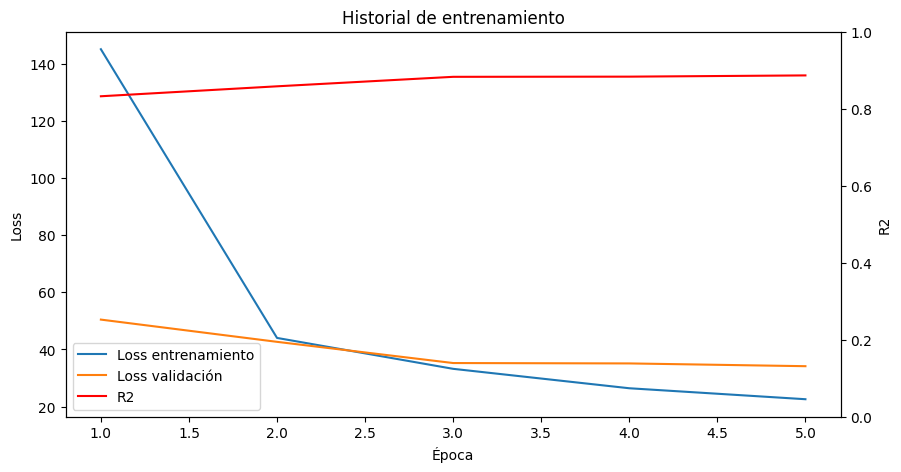

In [24]:
# Historial de entrenamiento

# Obtener loss y val_loss
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Obtener R2
if [x['eval_r2'] for x in history if 'eval_r2' in x] != []:
    metric = [x['eval_r2'] for x in history if 'eval_r2' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Crear plot 
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Graficar loss y val_loss
line1 = ax1.plot(epochs, loss, label='Loss entrenamiento')
line2 = ax1.plot(epochs, val_loss, label='Loss validación')
ax1.set_xlabel('Época')
ax1.set_ylabel('Loss')

# Graficar R2
line3 = ax2.plot(epochs, metric, color='red', label='R2')
ax2.set_ylabel('R2')
ax2.set_ylim([0, 1])

# Crear legenda
lines = line1 + line2 + line3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Mostrar el plot
plt.title("Historial de entrenamiento")
plt.savefig("./training_history_R2.svg", format="svg")
plt.show()

In [25]:
# Guardar el historial de entrenamiento en unarchivo de Excel

train_logs = []
eval_logs = []

for entry in history:
    if 'loss' in entry:
        train_logs.append(entry)
    elif 'eval_loss' in entry:
        eval_logs.append(entry)


train_df = pd.DataFrame(train_logs)
eval_df = pd.DataFrame(eval_logs)


merged_df = pd.merge(train_df, eval_df, on=['epoch', 'step'], how='outer')

final_df = merged_df.rename(columns={
    'loss': 'Training Loss',
    'eval_loss': 'Validation Loss',
    'eval_spearmanr': 'Spearmanr',
    'eval_r2': 'R2'
})[['epoch', 'Training Loss', 'Validation Loss', 'Spearmanr', 'R2']]


path= "./training_history_excel.xlsx"
final_df.to_excel(path, index=False)

## Guardar y  cargar el modelo con finetuning

In [26]:
def save_model(model,filepath):
# Guarda todos los parámetros que fueron cambiados durante el finetuning

    # Crear diccionario con los parametros no congelados
    non_frozen_params = {}

    # Iterar sobre todos los parametros del modelo
    for param_name, param in model.named_parameters():
        # si el parametro tiene requires_grad=True, añadirlo al diccionario
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Guardar solo los parametros con finetuned
    torch.save(non_frozen_params, filepath)

    
def load_model(filepath, num_labels=1, mixed = False):
# Crea un modelo PT5 nuevo y carga los pesos del finetuning de un archivo

    # Carga un modelo nuevo
    model, tokenizer = PT5_Regression_model(num_labels=num_labels, half_precision=False)
    
    # Carga los parámetros no congelados desde el archivo guardado
    non_frozen_params = torch.load(filepath)

    # Asigna los parametros no congelados a los parametros correspondientes del modelo
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

Esto guarda unicamente los pesos entrenados en el finetuning a un archivo .pth. Este es un archivo de aprox 14 MB, miesntras que todo el modelo presaría al rededor de 4.8 GB.

In [27]:
save_model(model,"./PT5_finetuned.pth")

# Evaluación

Para cargar los pesos de nuevo, se inicializa un modelo PT5 nuevo preentrenado y se cargan los pesos de LoRA.

In [28]:
tokenizer, model_reload = load_model("./PT5_finetuned.pth", num_labels=1, mixed=False)

loading configuration file config.json from cache at /home/sis.virtual.uniandes.edu.co/as.villa/.cache/huggingface/hub/models--Rostlab--prot_t5_xl_uniref50/snapshots/973be27c52ee6474de9c945952a8008aeb2a1a73/config.json
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 16384,
  "d_kv": 128,
  "d_model": 1024,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 24,
  "num_heads": 32,
  "num_layers": 24,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.26.1",
  "use_cache": true,
  "vocab_size": 128
}

loading weights file pytorch_model.bin from cache at /home/sis.virtual.uniandes.edu

ProtT5_Regressor
Arquitectura del modelo: T5EncoderModel(
  (shared): Embedding(128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=4096, bias=False)
              (k): Linear(in_features=1024, out_features=4096, bias=False)
              (v): Linear(in_features=1024, out_features=4096, bias=False)
              (o): Linear(in_features=4096, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 32)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=16384, bias=False)
              (wo): Linear(in_features=16384, out_features=1024, 

Para verificar que el modelo original y el modelo cargado son identicos, se comparan los pesos: 

In [29]:
# Cargar los dos modelos a la cpu
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterar sobre los parametros del modelo y comparar
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Los modelos no tienen pesos identicos")
        break
else:
    print("Los modelos tienen pesos identicos")

Los modelos tienen pesos identicos


In [31]:
# Conjunto de evaluación
my_test

,sequence,label
14045,RGCKAFFKRTIRKDLTYTCRDIKECLIDKRQRNRCQYCRYQKCLAM...,53.295000
29025,MSKNNGKGAKGEFEFPQPAKKQTFSEMIYNPQEGTFFGRTGKSWSQ...,43.466000
25672,MYISLENDYVARVPPELLGDDYREAVLEITKRNLVGKLVDINDSTG...,77.379000
4306,MTAFLPPNLLALFEARPPVQYLPPCQDLLVDKNAKRAPMTGVAQYI...,33.498000
8278,MRAIRVHEVGGPEVLRLEELPVPEPGPGEVLVRLLAIGVNFIDTYK...,78.824346
...,...,...
12531,MKRKSKAGGASDKSKSPKLKKRRSVVLEPIHISPKYLEDKFKTEFK...,33.837000
6725,MKLIRGIHNLSQAPQEGCVLTIGNFDGVHRGHRALLQGLQEEGRKR...,47.054000
11189,MSGLRNTSEAVAVLASLGLGMVLLMFVATTPPAVEATQSGIYIDNG...,37.881000
27334,MEIKEEPCRIKDEETEELIDQTEVNEDKQNLFNNPEGFSGENPQIK...,50.711000


In [32]:
# Preprocesar las secuencias
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)
my_test

,sequence,label
14045,R G C K A F F K R T I R K D L T Y T C R D I K ...,53.295000
29025,M S K N N G K G A K G E F E F P Q P A K K Q T ...,43.466000
25672,M Y I S L E N D Y V A R V P P E L L G D D Y R ...,77.379000
4306,M T A F L P P N L L A L F E A R P P V Q Y L P ...,33.498000
8278,M R A I R V H E V G G P E V L R L E E L P V P ...,78.824346
...,...,...
12531,M K R K S K A G G A S D K S K S P K L K K R R ...,33.837000
6725,M K L I R G I H N L S Q A P Q E G C V L T I G ...,47.054000
11189,M S G L R N T S E A V A V L A S L G L G M V L ...,37.881000
27334,M E I K E E P C R I K D E E T E E L I D Q T E ...,50.711000


Ahora se realizan predicciones con los datos de prueba usando el modelo al que se le realizó *finetuning*

In [33]:
#Usar el modelo cargado al que se le realizó finetuning
model = model_reload
del model_reload

# Establecer la GPU a utilizar
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Crear Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))

# Hacerlo compatible con el DataLoader de torch
test_set = test_set.with_format("torch", device=device)

# Crear un dataloader para le dataset de prueba
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Poner al modelo en modo de evaluación
model.eval()

# Hacer predicciones con los datos de evaluación
predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        predictions += model(input_ids, attention_mask=attention_mask).logits.tolist()

100%|█████████████████████████████████████████| 187/187 [05:55<00:00,  1.90s/it]


## Metricas de evaluación

In [34]:
y_true =my_test.label.values.flatten()
y_true

array([53.295, 43.466, 77.379, ..., 37.881, 50.711, 47.275])

In [35]:
y_pred = np.array(predictions).flatten()
y_pred

array([47.98324966, 47.35077667, 79.68850708, ..., 47.97563171,
       52.2239151 , 51.72698593])

In [36]:
# spearman
print(stats.spearmanr(a=predictions, b=my_test.label, axis=0))

SpearmanrResult(correlation=0.9021497215998552, pvalue=0.0)


In [37]:
# Generar reporte de evaluación y guardarlo en un archivo Excel

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# Metricas
start = time.time()
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
end = time.time()
runtime = round(end - start, 4)

# Imprimir Metrics
print(" Métricas del modelo:")
print(f" - MSE: {mse:.4f}")
print(f" - MAE: {mae:.4f}")
print(f" - R² : {r2:.4f}")
print(f" - Runtime: {runtime:.4f} s")

# Guardar metricas en un df
metrics_df = pd.DataFrame([{
    "Model": "Finetuned_T5",
    "MSE": round(mse, 4),
    "MAE": round(mae, 4),
    "R2": round(r2, 4),
    "Runtime (s)": runtime
}])

# Guardar archivo Excel con las métricas

path = "./metricas.xlsx"
metrics_df.to_excel(path, index=False)


 Métricas del modelo:
 - MSE: 31.3382
 - MAE: 4.0284
 - R² : 0.8980
 - Runtime: 0.0010 s


### Comparación de Tm real vs Predicha

In [52]:
# Guardar los reales vs predichos en un archivo excel

df = pd.DataFrame({
    "Real": y_true,              
    "Predicha": y_pred
})


path = "./Real_vs_Predicted.xlsx"
df.to_excel(path, index=False)

df


,Real,Predicha
0,53.295000,47.983250
1,43.466000,47.350777
2,77.379000,79.688507
3,33.498000,30.654524
4,78.824346,76.126343
...,...,...
2973,33.837000,38.352730
2974,47.054000,51.941433
2975,37.881000,47.975632
2976,50.711000,52.223915


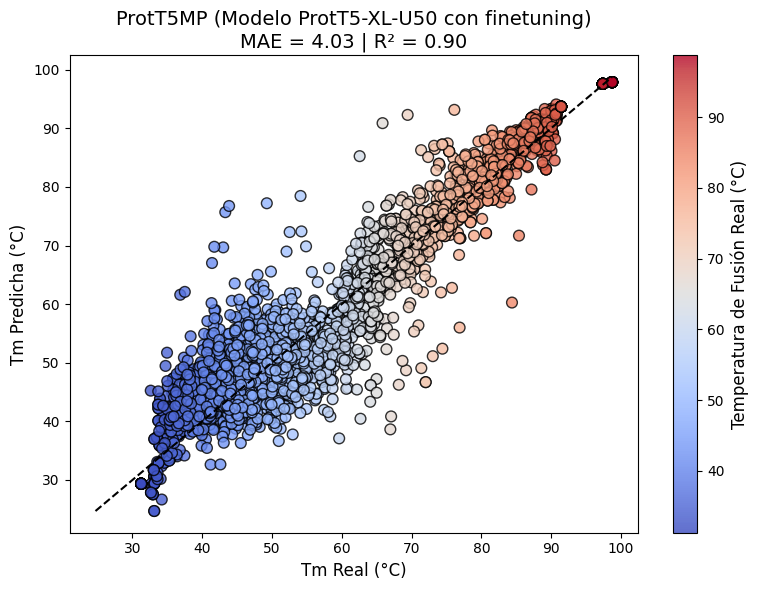

In [60]:
# Grafica reales vs predichos 

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

def graficar_predicciones_vs_reales(y_test, y_pred,filename, std_devs=None, title="Temperatura de fusión Reales vs Predichos"):
    """
    Genera un gráfico de dispersión comparando las temperaturas de fusión medidas y predichas,
    coloreando con un gradiente continuo según los valores reales de Tm (y_test), y mostrando
    la línea de predicción perfecta, junto con métricas de evaluación (MAE y R²).

    Parámetros:
    - y_test: array de valores de Tm reales (medidos).
    - y_pred: array de valores de Tm predichos.
    - std_devs: array de desviaciones estándar de las predicciones (opcional).
    - title: título del gráfico.
    """
    # Calcular métricas
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Crear figura
    plt.figure(figsize=(8, 6))

    # Crear scatter con color continuo
    scatter = plt.scatter(
        y_test,
        y_pred,
        c=y_test,  # Colorear por valor real
        cmap="coolwarm",
        s=60,
        alpha=0.8,
        edgecolor='k'
    )

    # Línea de predicción perfecta
    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1.5)

    # Barra de color
    cbar = plt.colorbar(scatter)
    cbar.set_label("Temperatura de Fusión Real (°C)", fontsize=12)

    # Desviaciones estándar
    if std_devs is not None:
        plt.errorbar(y_test, y_pred, yerr=std_devs, fmt='o', linestyle='none', color='gray', alpha=0.4)


    # Etiquetas y título
    plt.xlabel("Tm Real (°C)", fontsize=12)
    plt.ylabel("Tm Predicha (°C)", fontsize=12)
    plt.title(f"{title}\nMAE = {mae:.2f} | R² = {r2:.2f}", fontsize=14)
    plt.tight_layout()
    # Guardar la figura
    plt.savefig(f"{filename}.png", dpi=300)
    plt.savefig(f"{filename}.svg")

    plt.show()
    

graficar_predicciones_vs_reales(y_true, y_pred,filename=" Grafico_Reales_vs_Predicho", title="ProtT5MP (Modelo ProtT5-XL-U50 con finetuning)")

